# Energy Forcasting - Time Series Analysis Using FBProphet

### Objective

Load forcasting is a critical problem in the energy sector. It is a technique used by electricity companies to predict the power needed for the demand and supply. It allows for better planning and management of resources and not only helps in reducing the cost of electricity but also helps in reducing the carbon footprint by reducing the wastage of energy.

In this notebook, we will approach this problem using a regression analysis using XGBoost to forecast the energy load.

In [1]:
from utils.clean_data import mean_absolute_percentage_error, missing_data
from utils.preprocess import create_timeseries_features

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns


from prophet import Prophet


colour_pal = sns.color_palette('flare')

/Users/sjo/miniforge3/envs/playground/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


AttributeError: `np.float_` was removed in the NumPy 2.0 release. Use `np.float64` instead.

### Load DataSet (PJM East)

In [92]:
pjme = pd.read_csv('DataSet/Regions/PJME_hourly.csv', index_col=[0], parse_dates=[0])
pjme.head(10)


,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
2002-12-31 06:00:00,26222.0
2002-12-31 07:00:00,28702.0
2002-12-31 08:00:00,30698.0
2002-12-31 09:00:00,31800.0


In [5]:
#Check for missing data
missing_data(pjme)

,Total,Percent,Types
PJME_MW,0,0.0,float64


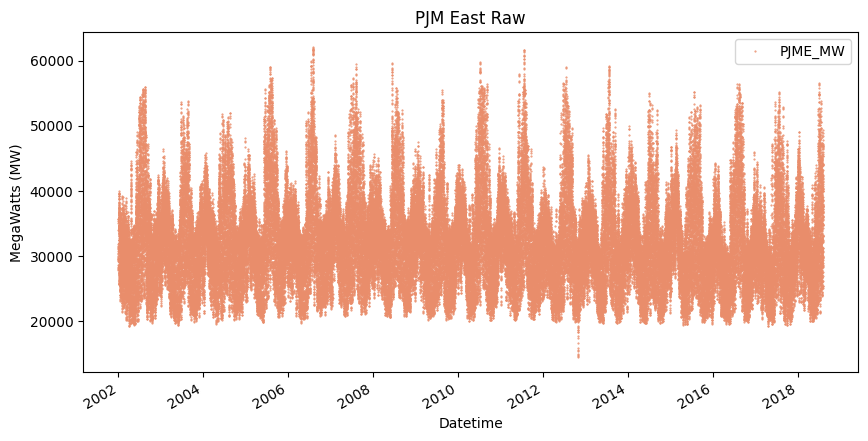

In [6]:
pjme.plot(style='.', figsize=(10,5),ms=1, color=colour_pal,ylabel='MegaWatts (MW)', title='PJM East Raw')
plt.show()

### Outlier Analysis and Data Distribution

In [7]:
pjme.describe()

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


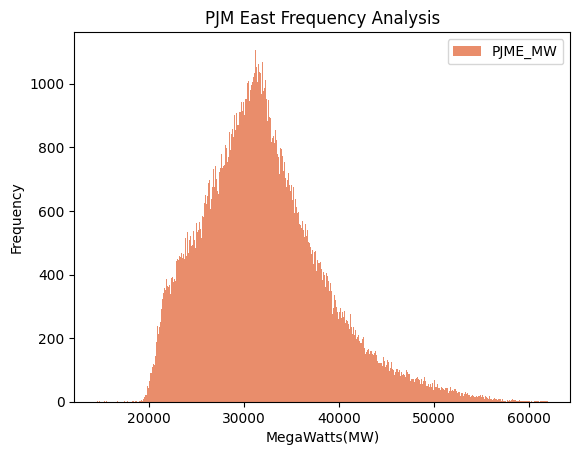

In [8]:
pjme.plot(kind='hist', bins=500, color=colour_pal,xlabel='MegaWatts(MW)', title='PJM East Frequency Analysis')
plt.show()

In [9]:
z_score = stats.zscore(pjme)
upper_threshold = (z_score > 3).all(axis=1)
lower_threshold = (z_score < -2).all(axis=1)
pjme_upper = pjme[upper_threshold]
pjme_lower = pjme[lower_threshold]

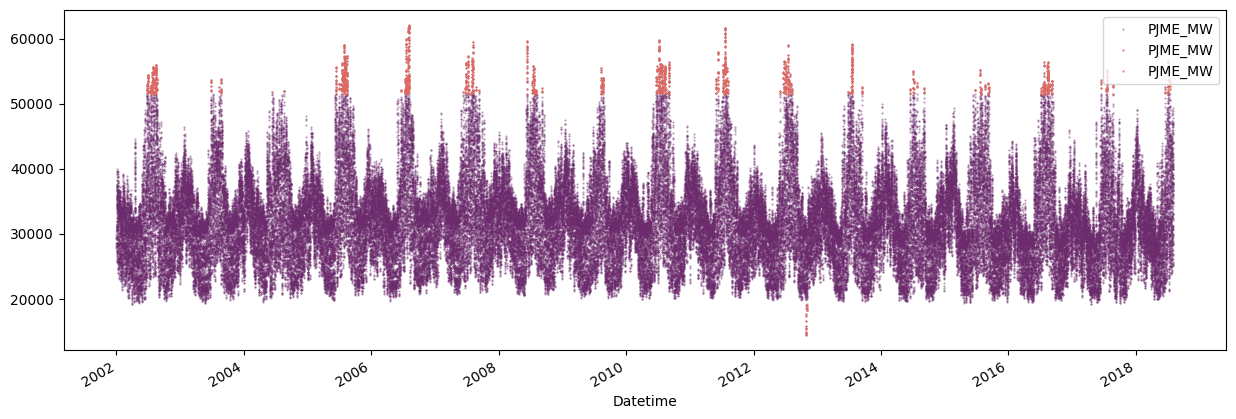

In [10]:
fig, ax = plt.subplots(figsize=(15, 5))
pjme.plot(style='.', ms=1, color=colour_pal[5], alpha=0.5,ax=ax)
pjme_upper.plot(style='.', ax=ax, ms=1, color=colour_pal[1])
pjme_lower.plot(style='.', ax=ax, ms=1, color=colour_pal[1])
plt.show()

In [79]:
print(pjme_lower.max(), pjme_upper.min())

PJME_MW    19085.0
dtype: float64 PJME_MW    51473.0
dtype: float64


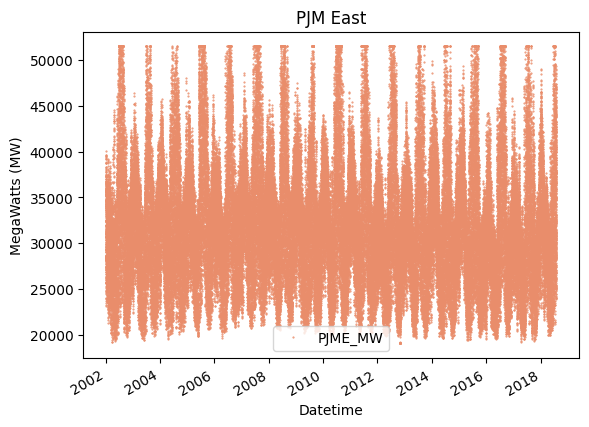

<Figure size 640x480 with 0 Axes>

In [93]:

pjme['PJME_MW'] = pjme['PJME_MW'].clip(upper=51472, lower=19085)
pjme.plot(style='.', ms=1, color=colour_pal,
          ylabel='MegaWatts (MW)', title='PJM East')
plt.show()
plt.clf()

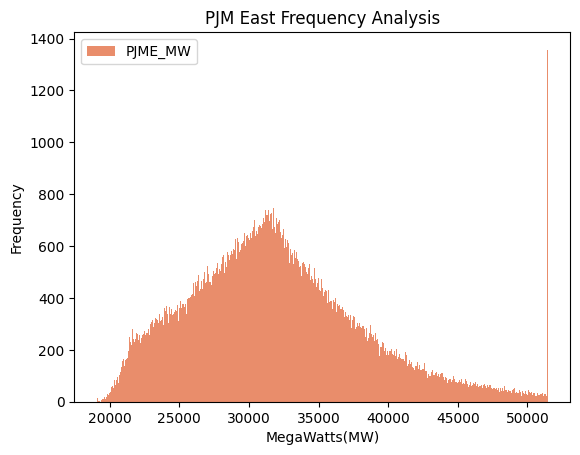

In [94]:
pjme.plot(kind='hist', bins=500, color=colour_pal, xlabel='MegaWatts(MW)', title='PJM East Frequency Analysis')
plt.show()

## Train Test Split

In [35]:
print('Min:', min(pjme.index), 'Max:', max(pjme.index), 'Timedelta:', (max(pjme.index)-min(pjme.index)))

Min: 2002-01-01 01:00:00 Max: 2018-08-03 00:00:00 Timedelta: 6057 days 23:00:00


In [86]:
pjme_train = pjme.loc[pjme.index < '01-01-2015']
pjme_test = pjme.loc[pjme.index >= '01-01-2015']

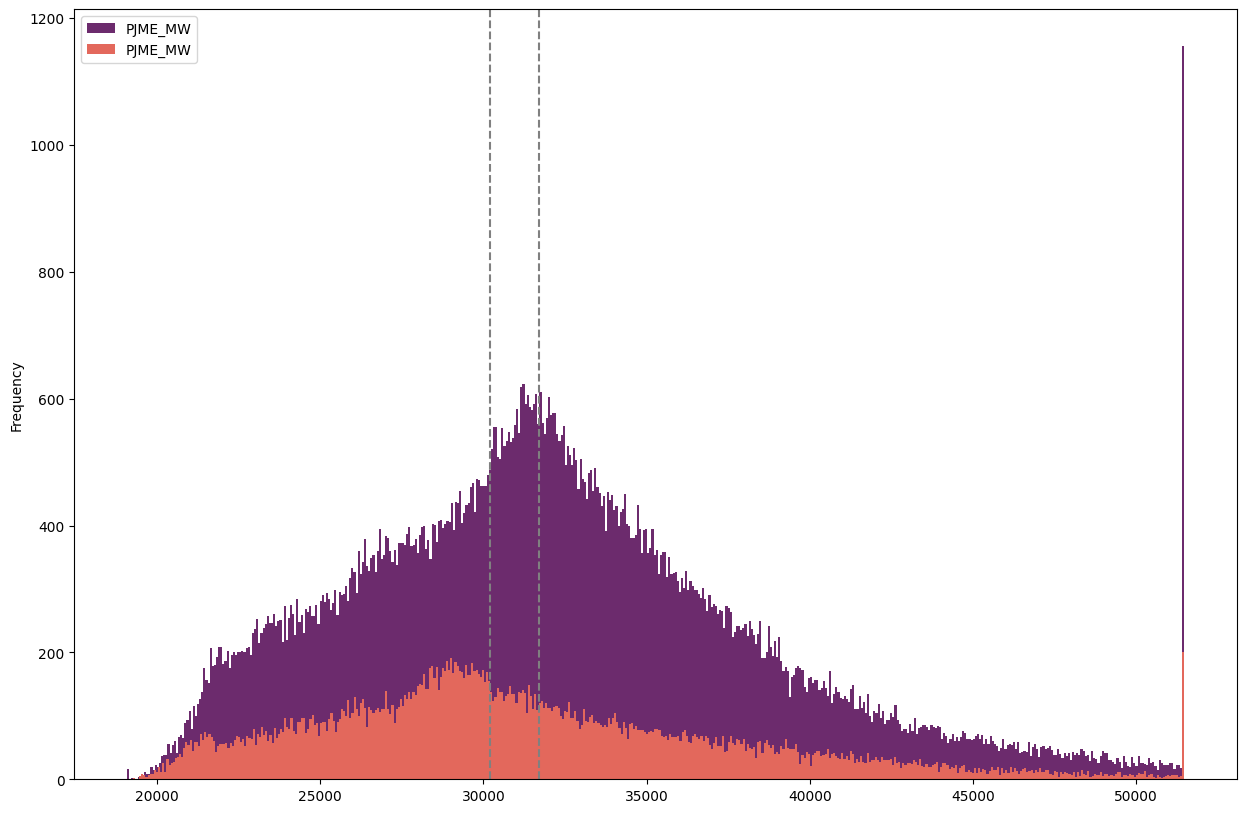

<Figure size 640x480 with 0 Axes>

In [89]:
fig, ax = plt.subplots(figsize=(15, 10))
pjme_train.plot(kind='hist', bins=500, color=colour_pal[5], ax=ax)
pjme_test.plot(kind='hist', bins=500, color=colour_pal[1], ax=ax)
plt.axvline(np.median(pjme_train['PJME_MW']), color='grey', ls='--')
plt.axvline(np.median(pjme_test['PJME_MW']), color='grey', ls='--')
plt.show()
plt.clf()

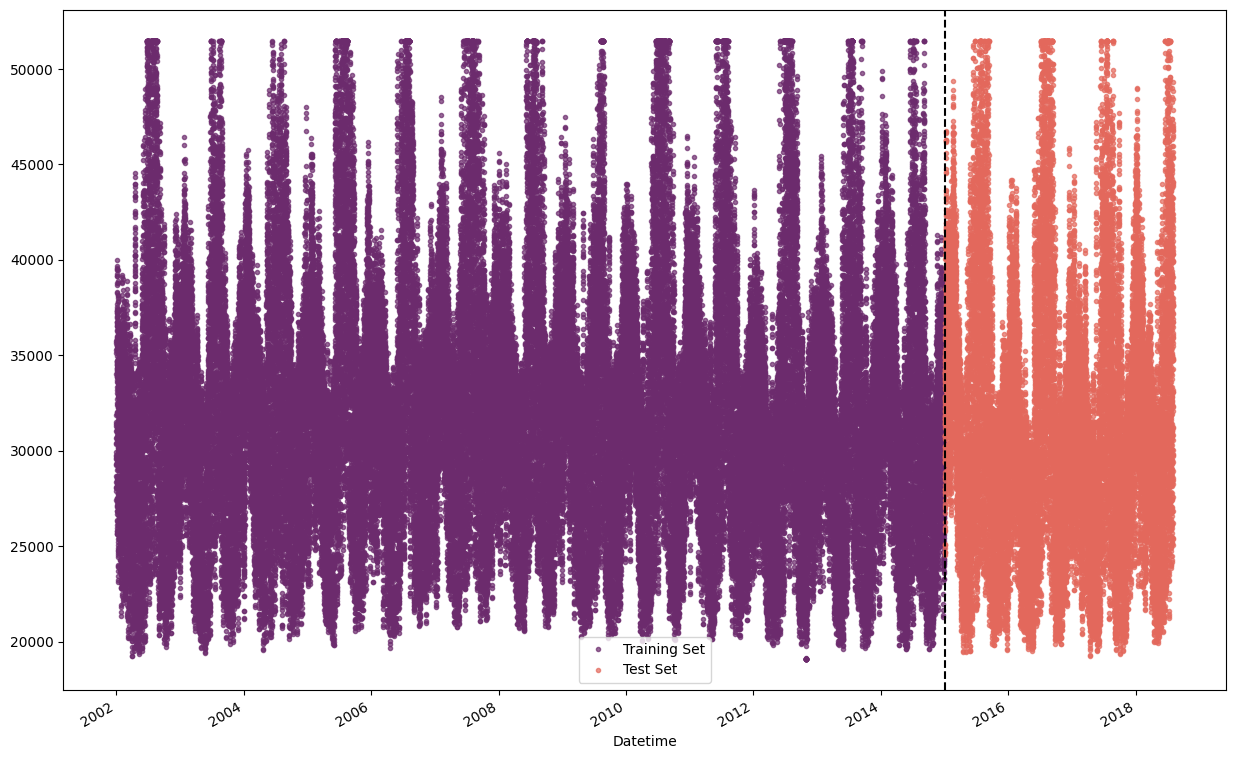

In [102]:
fig, ax = plt.subplots(figsize=(15, 10))
pjme_train.plot(style='.',color=colour_pal[5], ax=ax, alpha=0.7)
pjme_test.plot(style='.', color=colour_pal[1], ax=ax, alpha=0.7)
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

### Feature Creation

In [44]:
X_train, y_train = create_timeseries_features(pjme_train, label='PJME_MW')
features_and_target = pd.concat([X_train, y_train], axis=1)

### Visualizing Potential Seasonalities (Feature Target)
- Feature to target relationships

#### By Hour

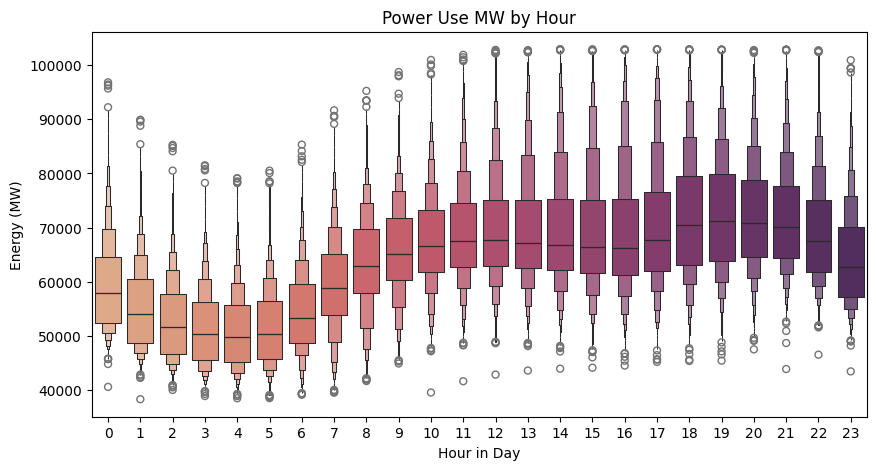

In [45]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxenplot(data=features_and_target.dropna(),
              x='hour',
              y='PJME_MW',
              palette='flare',
              ax=ax)
ax.set_title('Power Use MW by Hour')
ax.set_xlabel('Hour in Day')
ax.set_ylabel('Energy (MW)')
plt.show()

#### By Weekday

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


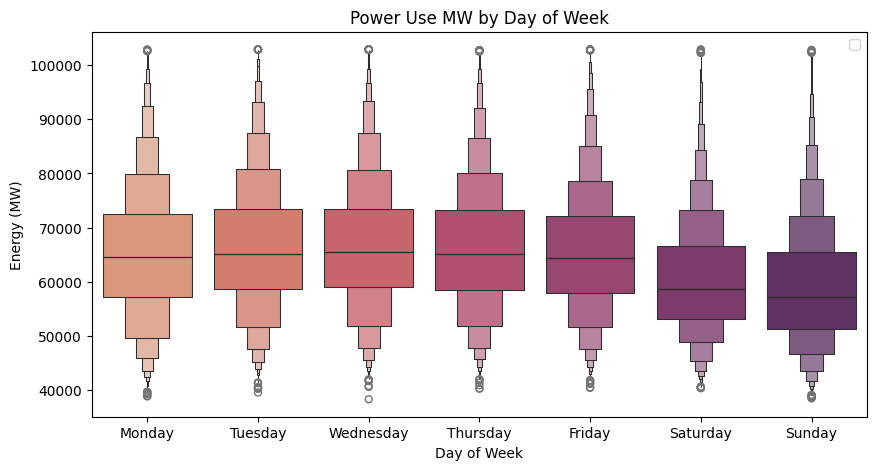

In [35]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxenplot(data=features_and_target.dropna(),
              x='weekday',
              y='PJME_MW',
              palette='flare',
              ax=ax)
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

#### By Month

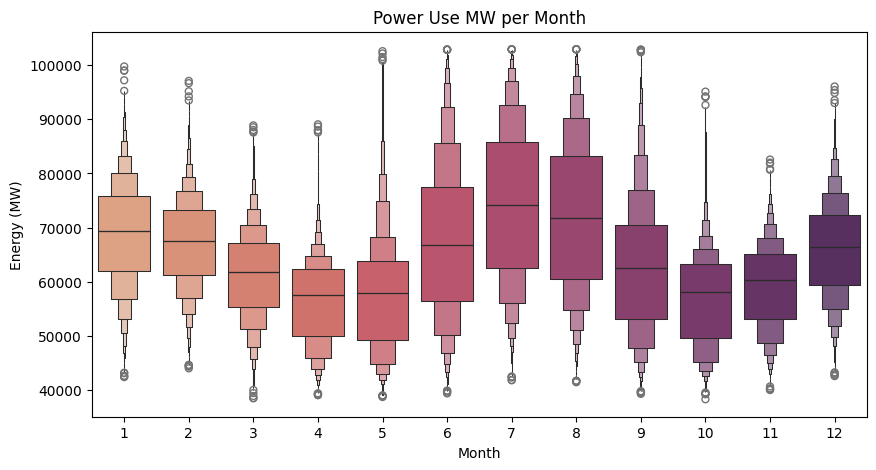

In [34]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxenplot(data=features_and_target.dropna(),
              x='month',
              y='PJME_MW',
              palette='flare',
              ax=ax)
ax.set_title('Power Use MW per Month')
ax.set_xlabel('Month')
ax.set_ylabel('Energy (MW)')
plt.show()

#### By Day of Year

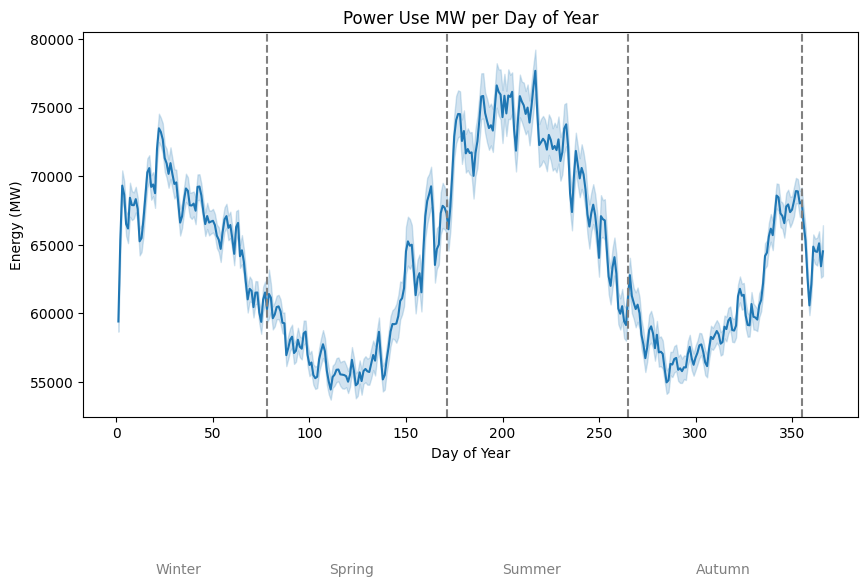

In [32]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=features_and_target.dropna(),
              x='dayofyear',
              y='PJME_MW',
              palette=colour_pal[2],
              ax=ax)
ax.set_title('Power Use MW per Day of Year')
ax.set_xlabel('Day of Year')
ax.set_ylabel('Energy (MW)')
plt.axvline(78,color='grey',linestyle='--')
ax.text(110,41000,'Spring', color='grey')
plt.axvline(171,color='grey',linestyle='--')
ax.text(200, 41000, 'Summer', color='grey')
plt.axvline(265,color='grey',linestyle='--')
ax.text(300, 41000, 'Autumn', color='grey')
plt.axvline(355,color='grey',linestyle='--')
ax.text(20, 41000, 'Winter', color='grey')

plt.show()

#### By Season

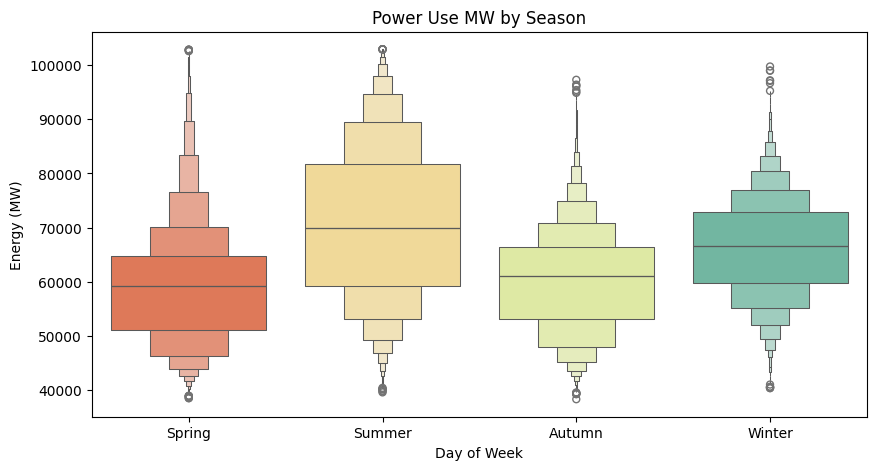

In [33]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxenplot(data=features_and_target.dropna(),
            x='season',
            y='PJME_MW',
            palette='Spectral',
            ax=ax)
ax.set_title('Power Use MW by Season')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
plt.show()

#### Add Holidays

In [115]:
cal = calendar()
holidays = cal.holidays(start=pjme.index.min(),
                        end=pjme.index.max(),
                        return_name=True)
holiday_df = pd.DataFrame(data=holidays,
                          columns=['holiday'])
holiday_df = holiday_df.reset_index().rename(columns={'index': 'ds'})
holiday_df

,ds,holiday
0,2002-01-21,"Birthday of Martin Luther King, Jr."
1,2002-02-18,Washington's Birthday
2,2002-05-27,Memorial Day
3,2002-07-04,Independence Day
4,2002-09-02,Labor Day
...,...,...
159,2018-01-01,New Year's Day
160,2018-01-15,"Birthday of Martin Luther King, Jr."
161,2018-02-19,Washington's Birthday
162,2018-05-28,Memorial Day


### Initial XGBoost Model

In [103]:
train = create_timeseries_features(pjme_train)
test = create_timeseries_features(pjme_test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = pjme_train

X_test = test[FEATURES]
y_test = pjme_test

In [38]:
encode = pd.get_dummies(X_train['season'])
encode_day = pd.get_dummies(X_train['weekday'])
X_train = pd.concat([X_train, encode, encode_day], axis=1)
X_train = X_train.drop(['season', 'weekday'], axis=1)

In [104]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:32561.24356	validation_1-rmse:31640.91971
[100]	validation_0-rmse:12544.36811	validation_1-rmse:11744.06606
[200]	validation_0-rmse:5781.07023	validation_1-rmse:5359.03459
[300]	validation_0-rmse:3854.98006	validation_1-rmse:4004.21648
[400]	validation_0-rmse:3375.95214	validation_1-rmse:3839.86599
[500]	validation_0-rmse:3217.76509	validation_1-rmse:3790.68030
[600]	validation_0-rmse:3136.27775	validation_1-rmse:3749.54271
[700]	validation_0-rmse:3082.13750	validation_1-rmse:3727.17402
[800]	validation_0-rmse:3043.21999	validation_1-rmse:3714.97033
[900]	validation_0-rmse:3011.48345	validation_1-rmse:3708.13160
[999]	validation_0-rmse:2984.38732	validation_1-rmse:3705.69575


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [105]:
y_pred = reg.predict(X_test)

In [106]:
print('RMSE:', np.sqrt(mean_squared_error(y_true=y_test,
                                          y_pred=y_pred)))

RMSE: 3705.640143832669


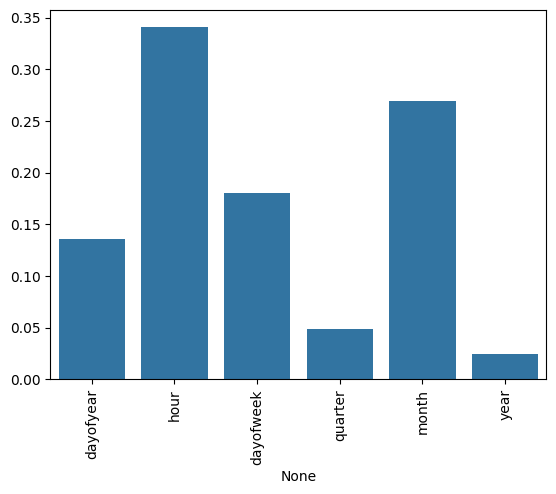

In [107]:
sns.barplot(x=X_train.columns, y=reg.feature_importances_)
plt.xticks(rotation=90)
plt.show()

In [108]:
# Create the parameter dictionary: params
params = {"objective": "reg:squarederror", "max_depth": 4}
dmatrix = xgb.DMatrix(data=X_train, label=y_train)

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=dmatrix, params=params, nfold=5,
                    num_boost_round=5, metrics="rmse", as_pandas=True, shuffle=False, seed=123)
print(cv_results)

   train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0      5349.677554       43.860205     5370.181587      43.006876
1      4631.815462       35.524642     4664.145649      71.053437
2      4175.917204       40.394050     4229.736824      84.852706
3      3919.976610       49.177531     3998.055011     108.094703
4      3689.188003       41.242016     3779.216082      90.204732


### Initial Prophet Model

In [113]:
pjme_train_prophet = pjme_train.reset_index() \
    .rename(columns={'Datetime': 'ds',
                     'PJME_MW': 'y'})

In [116]:
%%time
model = Prophet(holidays=holiday_df)
model.fit(pjme_train_prophet)

11:12:12 - cmdstanpy - INFO - Chain [1] start processing
11:12:36 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 3.51 s, sys: 107 ms, total: 3.61 s
Wall time: 28.2 s


In [117]:
pjme_test_prophet = pjme_test.reset_index() \
    .rename(columns={'Datetime': 'ds',
                     'PJME_MW': 'y'})
pjme_test_fcst = model.predict(pjme_test_prophet)

pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,"Birthday of Martin Luther King, Jr.","Birthday of Martin Luther King, Jr._lower","Birthday of Martin Luther King, Jr._upper",Christmas Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 00:00:00,31255.353469,22921.741534,31904.003805,31255.353469,31255.353469,0.0,0.0,0.0,0.0,...,1314.145529,1314.145529,1314.145529,624.643887,624.643887,624.643887,0.0,0.0,0.0,27553.969908
1,2015-01-01 01:00:00,31255.317796,20745.554547,29685.370646,31255.317796,31255.317796,0.0,0.0,0.0,0.0,...,1310.207647,1310.207647,1310.207647,625.506648,625.506648,625.506648,0.0,0.0,0.0,25533.816455
2,2015-01-01 02:00:00,31255.282123,19797.620863,28560.984713,31255.282123,31255.282123,0.0,0.0,0.0,0.0,...,1304.635517,1304.635517,1304.635517,626.403240,626.403240,626.403240,0.0,0.0,0.0,24033.722330
3,2015-01-01 03:00:00,31255.246451,18808.724291,27299.619511,31255.246451,31255.246451,0.0,0.0,0.0,0.0,...,1297.520627,1297.520627,1297.520627,627.333702,627.333702,627.333702,0.0,0.0,0.0,23164.943812
4,2015-01-01 04:00:00,31255.210778,18339.112157,27597.874330,31255.210778,31255.210778,0.0,0.0,0.0,0.0,...,1288.973527,1288.973527,1288.973527,628.298073,628.298073,628.298073,0.0,0.0,0.0,23024.654571


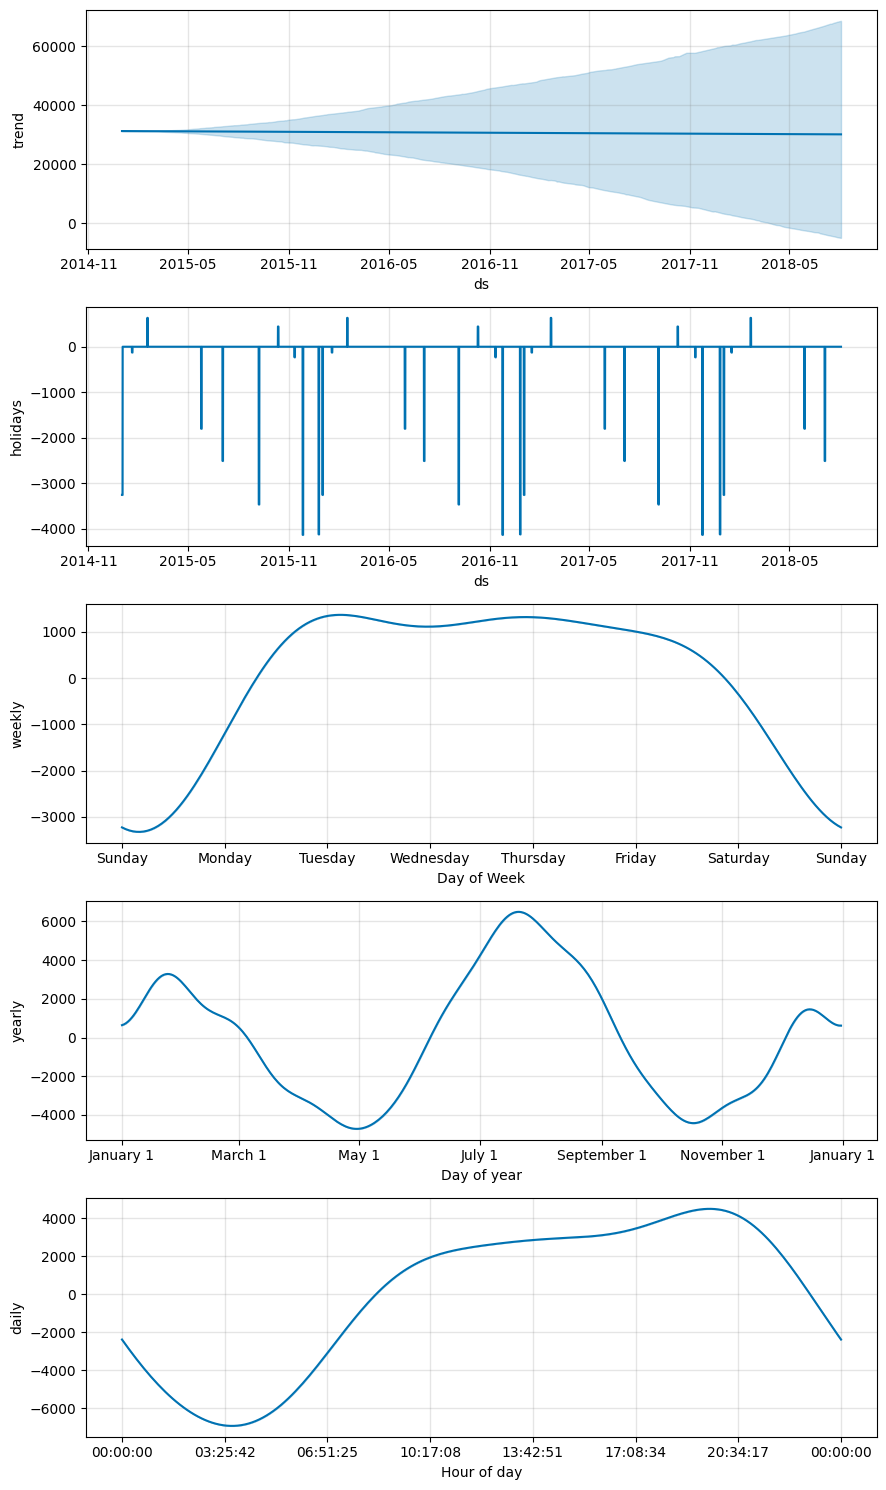

In [118]:

fig = model.plot_components(pjme_test_fcst)


### Visual Comparison of Forecast to Test

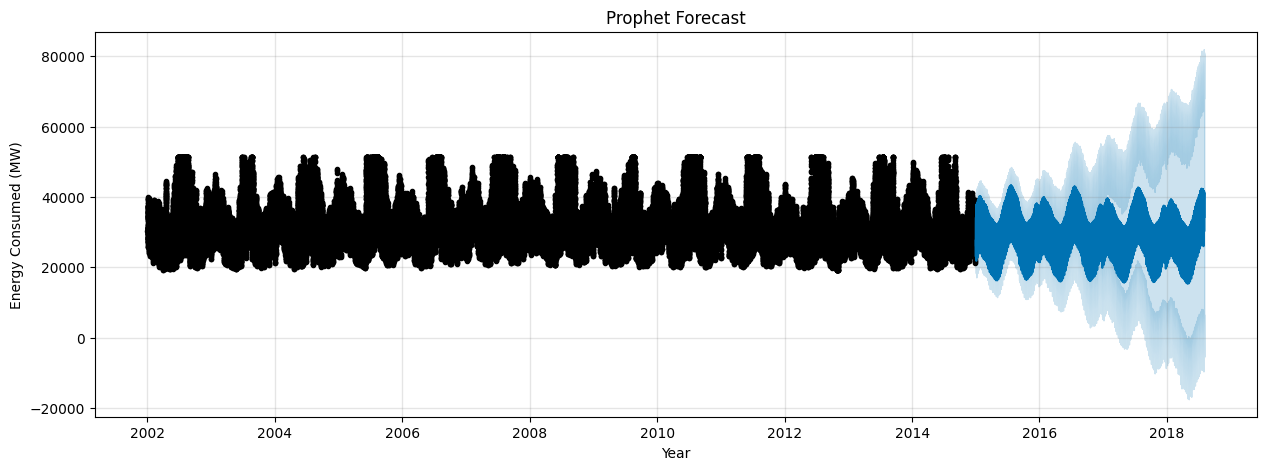

In [119]:
f, ax = plt.subplots(figsize=(15, 5))
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set(title='Prophet Forecast', xlabel='Year', ylabel='Energy Consumed (MW)')
plt.show()

#### For One Month

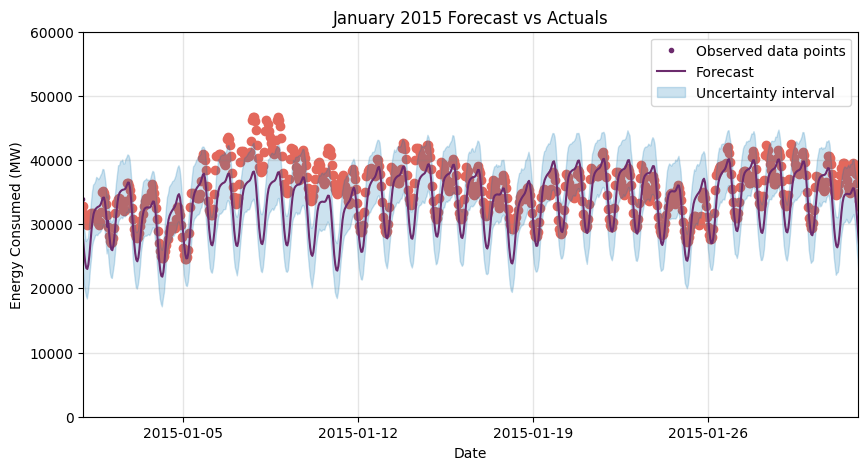

In [120]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color=colour_pal[1])
fig = model.plot(pjme_test_fcst, ax=ax)
for line in ax.get_lines():
    line.set_color(colour_pal[5])
ax.set_xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2015-02-01'))
ax.set_ylim(0, 60000)
ax.set(title='January 2015 Forecast vs Actuals',
       xlabel='Date', ylabel='Energy Consumed (MW)')
ax.legend()
plt.show()

#### For One Week

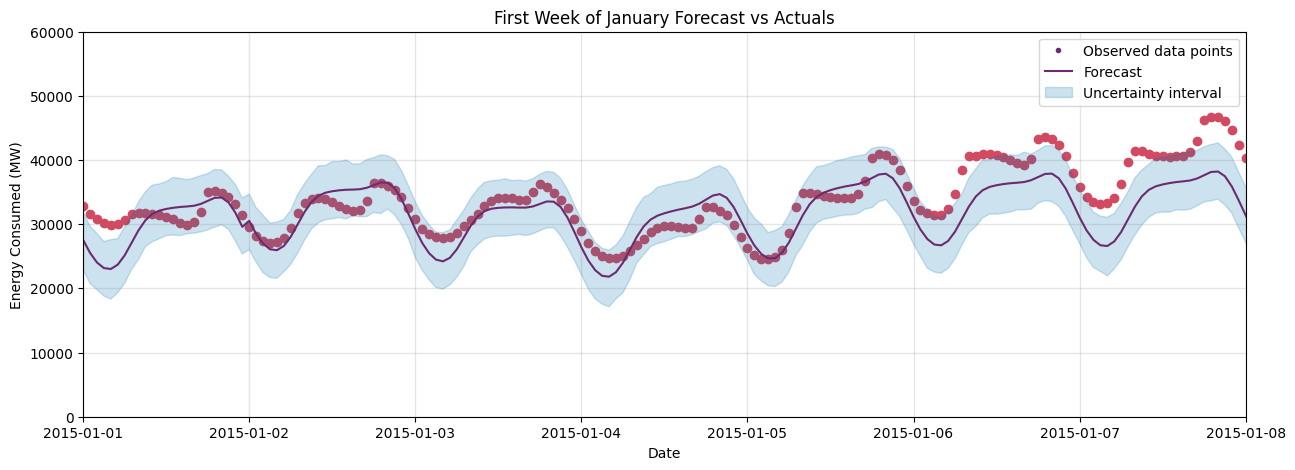

In [121]:
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color=colour_pal[2])
fig = model.plot(pjme_test_fcst, ax=ax)
for line in ax.get_lines():
    line.set_color(colour_pal[5])
ax.set_xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2015-01-08'))
ax.set_ylim(0, 60000)
ax.legend()
ax.set(title='First Week of January Forecast vs Actuals', xlabel='Date', ylabel='Energy Consumed (MW)')
plt.show()

### Evaluate Simple Model (Error Metrics)

In [122]:
print('RMSE:', np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                           y_pred=pjme_test_fcst['yhat'])))

RMSE: 6585.570822617259


In [123]:
print('MAPE:',mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                               y_pred=pjme_test_fcst['yhat']))

MAPE: 16.493466918889602


### Cross Validation

In [124]:
m = Prophet(holidays=holiday_df, seasonality_mode='multiplicative')
m.fit(pjme_train_prophet)
#730 hours = 1 month
cv_results = cross_validation(
    m, initial='111065 hours', period='730 hours', horizon='730 hours')

11:14:11 - cmdstanpy - INFO - Chain [1] start processing
11:14:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

11:14:56 - cmdstanpy - INFO - Chain [1] start processing
11:15:35 - cmdstanpy - INFO - Chain [1] done processing
11:15:39 - cmdstanpy - INFO - Chain [1] start processing
11:16:22 - cmdstanpy - INFO - Chain [1] done processing
11:16:26 - cmdstanpy - INFO - Chain [1] start processing
11:17:03 - cmdstanpy - INFO - Chain [1] done processing


In [125]:
cv_results['mape'] = (cv_results['y']-cv_results['yhat'])/(cv_results['y']) *100
cv_results['overestimate'] = cv_results['yhat'] > cv_results['y']
cv_results

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,mape,overestimate
0,2014-10-01 18:00:00,33516.774247,29789.763301,38150.958039,32030.0,2014-10-01 17:00:00,-4.641818,True
1,2014-10-01 19:00:00,33978.733180,29602.113264,37998.409975,32019.0,2014-10-01 17:00:00,-6.120532,True
2,2014-10-01 20:00:00,34033.844789,29674.948837,38405.584340,33026.0,2014-10-01 17:00:00,-3.051671,True
3,2014-10-01 21:00:00,33318.857842,29224.052222,37534.470597,32173.0,2014-10-01 17:00:00,-3.561551,True
4,2014-10-01 22:00:00,31753.510623,27111.291191,36184.252162,30281.0,2014-10-01 17:00:00,-4.862820,True
...,...,...,...,...,...,...,...,...
2186,2014-12-31 19:00:00,37622.974354,33390.893394,41830.872719,38906.0,2014-12-01 13:00:00,3.297758,False
2187,2014-12-31 20:00:00,37684.060341,33391.606915,42231.460072,37772.0,2014-12-01 13:00:00,0.232817,False
2188,2014-12-31 21:00:00,36977.777701,32751.022794,40975.902826,36602.0,2014-12-01 13:00:00,-1.026659,True
2189,2014-12-31 22:00:00,35428.778187,30814.009934,39829.713173,35326.0,2014-12-01 13:00:00,-0.290942,True


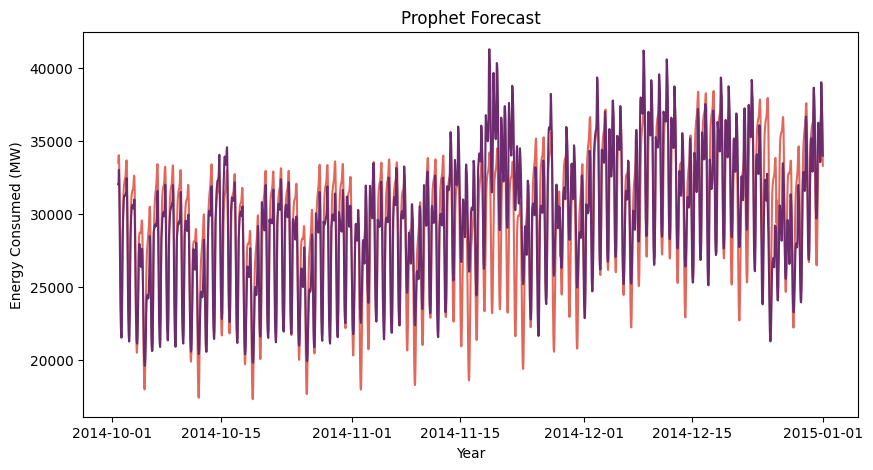

In [126]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(cv_results['ds'], cv_results['yhat'], color=colour_pal[1])
ax.plot(cv_results['ds'], cv_results['y'], color=colour_pal[5])
ax.set(title='Prophet Forecast', xlabel='Year', ylabel='Energy Consumed (MW)')
plt.show()

In [127]:
cv_metrics = performance_metrics(cv_results)
cv_metrics.tail()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
653,30 days 06:00:00,4.754104e+06,2180.390736,1860.288333,0.062614,0.056833,0.062601,0.972603
654,30 days 07:00:00,4.737009e+06,2176.467005,1851.543159,0.062311,0.056734,0.062309,0.972603
655,30 days 08:00:00,4.718934e+06,2172.310706,1840.090721,0.061879,0.056387,0.061890,0.972603
656,30 days 09:00:00,4.723368e+06,2173.331022,1832.993124,0.061618,0.055432,0.061638,0.972603
657,30 days 10:00:00,4.762348e+06,2182.280532,1834.965649,0.061674,0.055432,0.061692,0.968037


In [105]:
print('RMSE:', np.sqrt(mean_squared_error(y_true=cv_results['y'],
                                          y_pred=cv_results['yhat'])))

RMSE: 2415.560417870197


In [128]:
print('MAPE:', mean_absolute_percentage_error(y_true=cv_results['y'],
                                              y_pred=cv_results['yhat']))

MAPE: 6.619948178414678


## Tuning Prophet Model Hyperparameters

In [129]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

In [130]:
import itertools

#Generates all combinations of parameters
all_params = [dict(zip(param_grid.keys(),v)) for v in itertools.product(*param_grid.values())]

rmse = []

for param in all_params:
    pmodel = Prophet(holidays=holiday_df,seasonality_mode='multiplicative', **param).fit(pjme_train_prophet)
    df_cv = cross_validation(pmodel, initial='111065 hours', period='730 hours', horizon='730 hours', parallel='processes' )
    df_performance = performance_metrics(df_cv, rolling_window=1)
    rmse.append(df_performance['rmse'].iloc[0])

#Find Best Parameter
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmse

11:23:53 - cmdstanpy - INFO - Chain [1] start processing
11:23:57 - cmdstanpy - INFO - Chain [1] done processing
11:24:02 - cmdstanpy - INFO - Chain [1] start processing
11:24:02 - cmdstanpy - INFO - Chain [1] start processing
11:24:02 - cmdstanpy - INFO - Chain [1] start processing
11:24:08 - cmdstanpy - INFO - Chain [1] done processing
11:24:09 - cmdstanpy - INFO - Chain [1] done processing
11:24:12 - cmdstanpy - INFO - Chain [1] done processing
11:24:16 - cmdstanpy - INFO - Chain [1] start processing
11:24:20 - cmdstanpy - INFO - Chain [1] done processing
11:24:25 - cmdstanpy - INFO - Chain [1] start processing
11:24:25 - cmdstanpy - INFO - Chain [1] start processing
11:24:25 - cmdstanpy - INFO - Chain [1] start processing
11:24:32 - cmdstanpy - INFO - Chain [1] done processing
11:24:32 - cmdstanpy - INFO - Chain [1] done processing
11:24:33 - cmdstanpy - INFO - Chain [1] done processing
11:24:37 - cmdstanpy - INFO - Chain [1] start processing
11:24:47 - cmdstanpy - INFO - Chain [1]

In [131]:

print(tuning_results.head())

params_dict = dict(tuning_results.sort_values("rmse").reset_index(drop=True).iloc[0])
params_dict

   changepoint_prior_scale  seasonality_prior_scale         rmse
0                    0.001                     0.01  2478.269826
1                    0.001                     0.10  2484.889762
2                    0.001                     1.00  2479.814233
3                    0.001                    10.00  2481.176896
4                    0.010                     0.01  2496.830231


{'changepoint_prior_scale': 0.001,
 'seasonality_prior_scale': 0.01,
 'rmse': 2478.2698260521006}

### Backtesting With Tuned Metrics

In [132]:
m = Prophet(changepoint_prior_scale = 0.001,
             seasonality_prior_scale = 0.01,
            seasonality_mode='multiplicative',
             holidays= holiday_df)

m.fit(pjme_train_prophet)
cv_results = cross_validation(
    m, initial='111065 hours', period='730 hours', horizon='730 hours')
forecast = m.predict(pjme_test_prophet)

11:46:49 - cmdstanpy - INFO - Chain [1] start processing
11:46:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

11:46:58 - cmdstanpy - INFO - Chain [1] start processing
11:47:02 - cmdstanpy - INFO - Chain [1] done processing
11:47:06 - cmdstanpy - INFO - Chain [1] start processing
11:47:14 - cmdstanpy - INFO - Chain [1] done processing
11:47:18 - cmdstanpy - INFO - Chain [1] start processing
11:47:23 - cmdstanpy - INFO - Chain [1] done processing


In [133]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,"Birthday of Martin Luther King, Jr.","Birthday of Martin Luther King, Jr._lower","Birthday of Martin Luther King, Jr._upper",Christmas Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2015-01-01 00:00:00,31232.865222,23292.125621,32212.523938,31232.865222,31232.865222,0.0,0.0,0.0,0.0,...,0.040432,0.040432,0.040432,0.013809,0.013809,0.013809,0.0,0.0,0.0,27801.356729
1,2015-01-01 01:00:00,31232.832824,21632.565973,30027.608177,31232.832824,31232.832824,0.0,0.0,0.0,0.0,...,0.040310,0.040310,0.040310,0.013821,0.013821,0.013821,0.0,0.0,0.0,25851.453207
2,2015-01-01 02:00:00,31232.800426,19895.946865,28623.048917,31232.800426,31232.800426,0.0,0.0,0.0,0.0,...,0.040137,0.040137,0.040137,0.013834,0.013834,0.013834,0.0,0.0,0.0,24403.558732
3,2015-01-01 03:00:00,31232.768028,19001.370112,27872.541275,31232.768028,31232.768028,0.0,0.0,0.0,0.0,...,0.039918,0.039918,0.039918,0.013847,0.013847,0.013847,0.0,0.0,0.0,23564.920261
4,2015-01-01 04:00:00,31232.735630,18748.950009,27648.041235,31232.735630,31232.735630,0.0,0.0,0.0,0.0,...,0.039654,0.039654,0.039654,0.013862,0.013862,0.013862,0.0,0.0,0.0,23429.059073


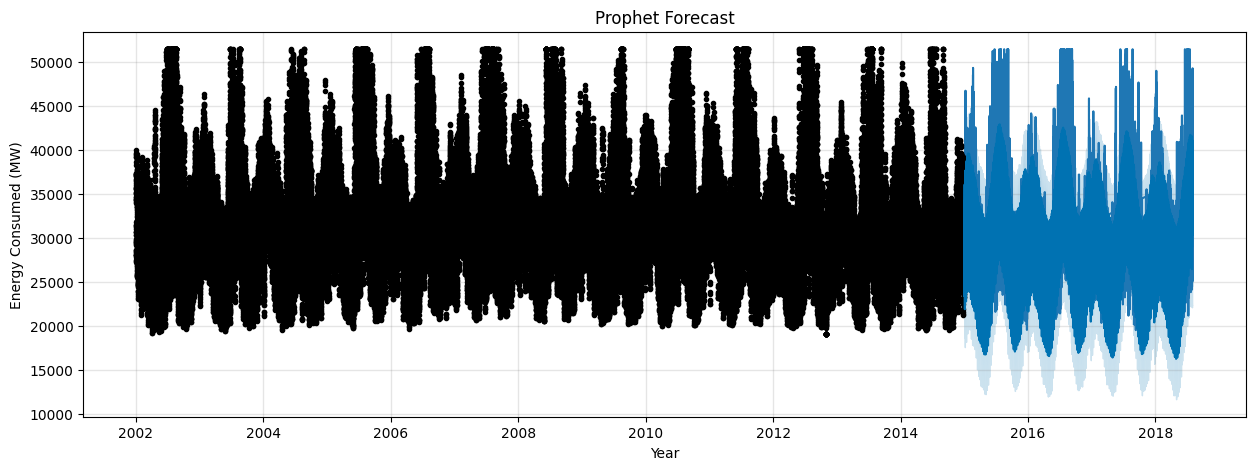

In [134]:
f, ax = plt.subplots(figsize=(15, 5))
ax.plot(pjme_test.index, pjme_test['PJME_MW'])
fig = m.plot(forecast, ax=ax)
ax.set(title='Prophet Forecast', xlabel='Year', ylabel='Energy Consumed (MW)')
plt.show()

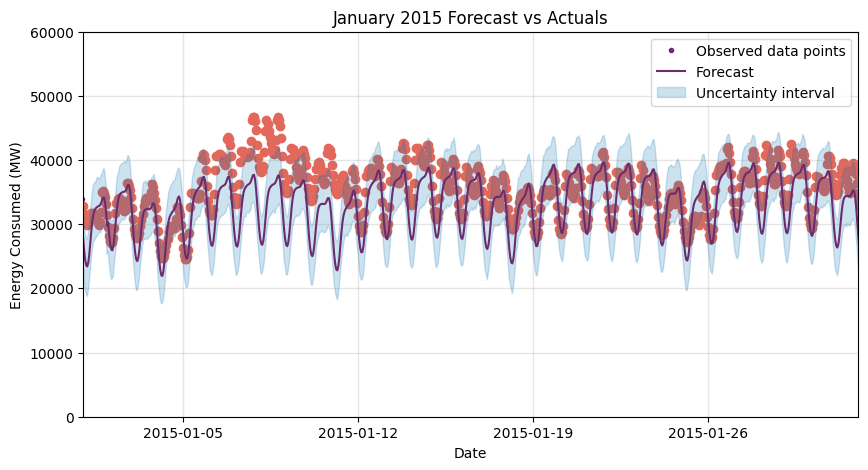

In [135]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color=colour_pal[1])
fig = m.plot(forecast, ax=ax)
for line in ax.get_lines():
    line.set_color(colour_pal[5])
ax.set_xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2015-02-01'))
ax.set_ylim(0, 60000)
ax.set(title='January 2015 Forecast vs Actuals',
       xlabel='Date', ylabel='Energy Consumed (MW)')
ax.legend()
plt.show()

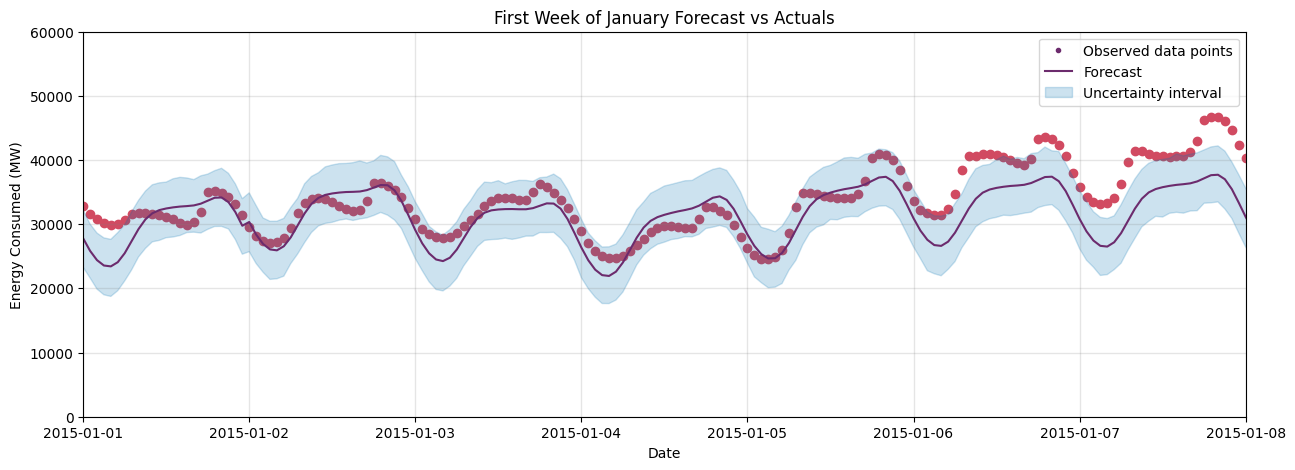

In [136]:
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color=colour_pal[2])
fig = m.plot(forecast, ax=ax)
for line in ax.get_lines():
    line.set_color(colour_pal[5])
ax.set_xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2015-01-08'))
ax.set_ylim(0, 60000)
ax.legend()
ax.set(title='First Week of January Forecast vs Actuals',
       xlabel='Date', ylabel='Energy Consumed (MW)')
plt.show()

In [137]:
print('RMSE:', np.sqrt(mean_squared_error(y_true=cv_results['y'],
                                          y_pred=cv_results['yhat'])))

RMSE: 2478.2698260521006


In [138]:
print('MAPE:', mean_absolute_percentage_error(y_true=cv_results['y'],
                                              y_pred=cv_results['yhat']))

MAPE: 6.4979963564653


### Predict into Future

In [139]:
future = m.make_future_dataframe(
    periods=365*24*4, freq='h', include_history=False)
forecast = m.predict(future)

In [140]:
forecast[['ds', 'yhat']].head()

,ds,yhat
0,2015-01-01 00:00:00,27801.356729
1,2015-01-01 01:00:00,25851.453207
2,2015-01-01 02:00:00,24403.558732
3,2015-01-01 03:00:00,23564.920261
4,2015-01-01 04:00:00,23429.059073


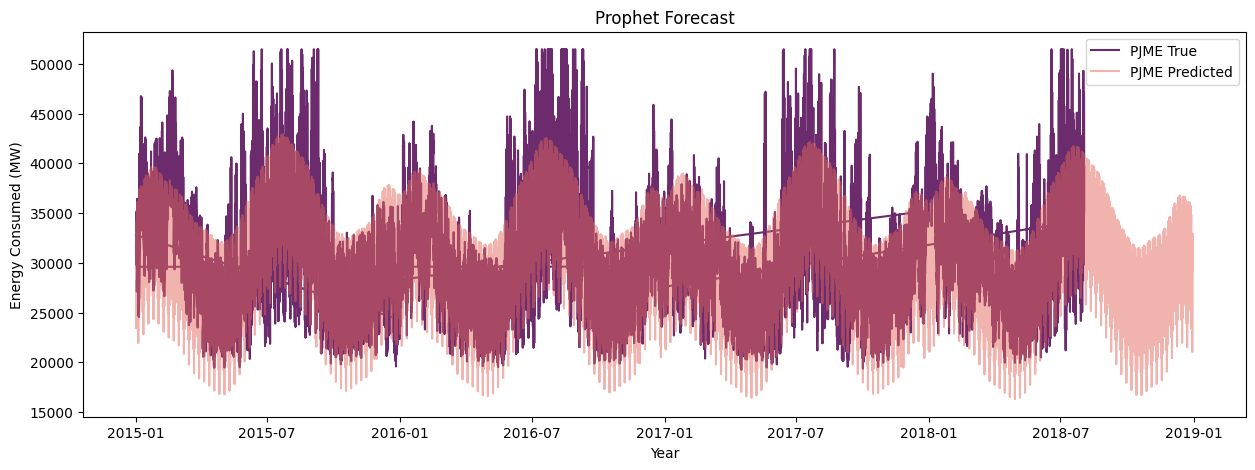

In [141]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(pjme_test.index, pjme_test['PJME_MW'], color=colour_pal[5], label='PJME True')
ax.plot(forecast['ds'], forecast['yhat'], alpha=0.5,
        color=colour_pal[1], label='PJME Predicted')
ax.set(title='Prophet Forecast', xlabel='Year', ylabel='Energy Consumed (MW)')
ax.legend()
plt.show()